### Case Study: Momentum Strategy

## Oanda API 

In [17]:
import tpqoa
import pandas as pd

In [18]:
oanda = tpqoa.tpqoa('oanda.cfg')

## The Data 

In [19]:
%%time
data = oanda.get_history(
    instrument='EUR_USD',
    start='2023-06-14',
    end='2023-06-15',
    granularity='M1',
    price='M'
)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1425 entries, 2023-06-14 00:00:00 to 2023-06-14 23:59:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         1425 non-null   float64
 1   h         1425 non-null   float64
 2   l         1425 non-null   float64
 3   c         1425 non-null   float64
 4   volume    1425 non-null   int64  
 5   complete  1425 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 68.2 KB
CPU times: total: 31.2 ms
Wall time: 800 ms


## The Strategy 

In [20]:
import numpy as np
data['r'] = np.log(data['c'] / data['c'].shift(1)) 
cols = []
for momentum in [15, 30, 60, 120, 150]:
    col = f'p_{momentum}'
    data[col] = np.sign(data['r'].rolling(momentum).mean())
    cols.append(col)

In [21]:
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

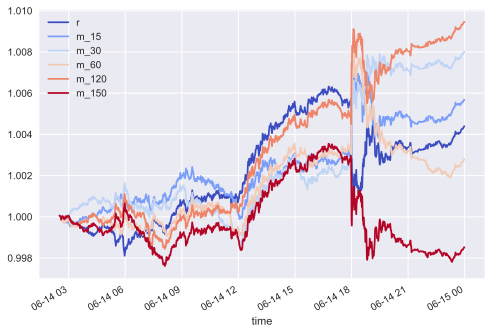

In [22]:
# backtesting
strats = ['r']
for col in cols:
    strat = f'm_{col[2:]}' 
    data[strat] = data[col].shift(1) * data['r']
    strats.append(strat)
data[strats].dropna().cumsum().apply(np.exp).plot(cmap='coolwarm');

## Trading Code

In [23]:
oanda.on_success??

Signature: oanda.on_success(time, bid, ask)
Source:   
    def on_success(self, time, bid, ask):
        ''' Method called when new data is retrieved. '''
        print(time, bid, ask)
File:      d:\2024\april\major project\env\lib\site-packages\tpqoa\tpqoa.py
Type:      method

In [24]:
oanda.stream_data('EUR_USD', stop=10)  # streaming data

2024-05-15T11:02:37.968208851Z 1.08248 1.08263
2024-05-15T11:02:42.654481107Z 1.0825 1.08265
2024-05-15T11:02:45.925092942Z 1.08248 1.08263
2024-05-15T11:02:49.904318968Z 1.0825 1.08265
2024-05-15T11:02:55.281533569Z 1.08248 1.08263
2024-05-15T11:03:02.287158970Z 1.0825 1.08264
2024-05-15T11:03:03.499837194Z 1.08248 1.08262
2024-05-15T11:03:06.114821627Z 1.08248 1.08262
2024-05-15T11:03:06.465237042Z 1.08246 1.08261
2024-05-15T11:03:07.070072416Z 1.08246 1.08261


In [25]:
oanda.create_order('EUR_USD', units=1000)  # opening long position



 {'id': '55', 'time': '2024-05-15T11:03:07.499583648Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '54', 'requestID': '115282856172067494', 'type': 'ORDER_FILL', 'orderID': '54', 'instrument': 'EUR_USD', 'units': '1000.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08261, 'fullVWAP': 1.08261, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08246, 'liquidity': '10000000'}], 'asks': [{'price': 1.08261, 'liquidity': '10000000'}], 'closeoutBid': 1.08246, 'closeoutAsk': 1.08261}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99979.23', 'tradeOpened': {'tradeID': '55', 'units': '1000.0', 'price': 1.08261, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.075', 'initialMarginRequired': '21.6508'}, 'halfSpreadCost': '0.075'} 



In [26]:
oanda.create_order('EUR_USD', units=-1000)  # closing long position



 {'id': '57', 'time': '2024-05-15T11:03:08.915773624Z', 'userID': 29105169, 'accountID': '101-001-29105169-001', 'batchID': '56', 'requestID': '79254059157869000', 'type': 'ORDER_FILL', 'orderID': '56', 'instrument': 'EUR_USD', 'units': '-1000.0', 'gainQuoteHomeConversionFactor': '1.0', 'lossQuoteHomeConversionFactor': '1.0', 'price': 1.08246, 'fullVWAP': 1.08246, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.08246, 'liquidity': '10000000'}], 'asks': [{'price': 1.08261, 'liquidity': '9999000'}], 'closeoutBid': 1.08246, 'closeoutAsk': 1.08261}, 'reason': 'MARKET_ORDER', 'pl': '-0.15', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '99979.08', 'tradesClosed': [{'tradeID': '55', 'units': '-1000.0', 'price': 1.08246, 'realizedPL': '-0.15', 'financing': '0.0', 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '0.075'}], 'halfSpreadCost': '0.075'} 



## Simple Deployment

In [27]:
class MomentumTrader(tpqoa.tpqoa):
    def __init__(self, config_file, momentum):
        super(MomentumTrader, self).__init__(config_file)
        self.momentum = momentum
        self.min_length = momentum + 1
        self.position = 0
        self.units = 10000
        self.tick_data = pd.DataFrame()
    def on_success(self, time, bid, ask):
        trade = False
        print(self.ticks, end=' ')
        df = pd.DataFrame({'b': bid, 'a': ask, 'm': (ask + bid) / 2},
                         index=[pd.Timestamp(time).tz_localize(tz=None)])
        self.tick_data = pd.concat((self.tick_data, df))
        # resampling the tick data to 5 second intervals
        self.data = self.tick_data.resample('5s', label='right').last().ffill()
        self.data['r'] = np.log(self.data['m'] / self.data['m'].shift(1))
        self.data['m'] = self.data['r'].rolling(self.momentum).mean()
        self.data.dropna(inplace=True)
        if len(self.data) > self.min_length:
            self.min_length += 1
            # checking for long signal
            if self.data['m'].iloc[-2] > 0 and self.position in [0, -1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=(1 - self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING LONG ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = 1
            # checking for short signal
            if self.data['m'].iloc[-2] < 0 and self.position in [0, 1]:
                o = oanda.create_order(self.stream_instrument,
                                   units=-(1 + self.position) * self.units,
                                   suppress=True, ret=True)
                print('\n*** GOING SHORT ***')
                self.print_transactions(tid=int(o['id']) - 1)
                self.position = -1    

In [28]:
mt = MomentumTrader('oanda.cfg', momentum=5)
mt.stream_data('EUR_USD', stop=50)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 
*** GOING SHORT ***
  59 | 2024-05-15T11:04:01.55 | EUR_USD | -10000.0 |      0.0
33 34 35 36 37 38 
*** GOING LONG ***
  61 | 2024-05-15T11:04:17.56 | EUR_USD |  20000.0 |     -1.5
39 40 41 
*** GOING SHORT ***
  63 | 2024-05-15T11:04:20.87 | EUR_USD | -20000.0 |     -1.7
42 43 44 45 46 47 48 49 50 

In [29]:
from pprint import pprint
o = mt.create_order('EUR_USD', units=-mt.position * mt.units,
                    suppress=True, ret = True)
print('\n*** POSITION CLOSED ***')
mt.print_transactions(tid=int(o['id']) - 1)
print('\n')
pprint(o)


*** POSITION CLOSED ***
  65 | 2024-05-15T11:04:35.04 | EUR_USD |  10000.0 |     -1.5


{'accountBalance': '99974.38',
 'accountID': '101-001-29105169-001',
 'batchID': '64',
 'commission': '0.0',
 'financing': '0.0',
 'fullPrice': {'asks': [{'liquidity': '10000000', 'price': 1.08258}],
               'bids': [{'liquidity': '10000000', 'price': 1.08243}],
               'closeoutAsk': 1.08258,
               'closeoutBid': 1.08243,
               'type': 'PRICE'},
 'fullVWAP': 1.08258,
 'gainQuoteHomeConversionFactor': '1.0',
 'guaranteedExecutionFee': '0.0',
 'halfSpreadCost': '0.75',
 'id': '65',
 'instrument': 'EUR_USD',
 'lossQuoteHomeConversionFactor': '1.0',
 'orderID': '64',
 'pl': '-1.5',
 'price': 1.08258,
 'reason': 'MARKET_ORDER',
 'requestID': '115282856541252711',
 'time': '2024-05-15T11:04:35.047435486Z',
 'tradesClosed': [{'financing': '0.0',
                   'guaranteedExecutionFee': '0.0',
                   'halfSpreadCost': '0.75',
                   'price': 1.08